# **Лабораторная работа №4**

**ФИО:** Янушка Артём Викторович

**Группа:** БИВТ-20-1

**Номер варианта:** 27

Мой датасет называется: "sasha/dog-food"

Данный датасет состоит из 2100 образцов для тренировки и 900 образцов для тестирования. 
В нем содержатся изображения, на которых присутствуют собаки и различные виды еды, сопровождаемые подписями. Цель обучения нейронной сети состоит в том, чтобы она научилась различать изображения собак и еды.

P.S.
При попытке использовать начальный датасет "Bingsu/Gameplay_Images" мой старенький ноутбук приказал долго жить ,поэтому датасет пришлось сменить.

#Установим необходимые зависимости и импортируем модули



In [84]:
!pip install datasets  
!pip install torch torchvision datasets matplotlib
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Загружаем датасет

In [85]:
from datasets import load_dataset
dataset = load_dataset('sasha/dog-food')  

  0%|          | 0/2 [00:00<?, ?it/s]

# 2. Описание датасета(описание сделано в заголовке) и примеры изображений

In [86]:
labels = dataset["test"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    print(i, label)
    label2id[label] = i
    id2label[i] = label

0 dog
1 food


In [87]:
example = dataset['train'][3]

In [88]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2100
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 900
    })
})

In [89]:
example['label']

0

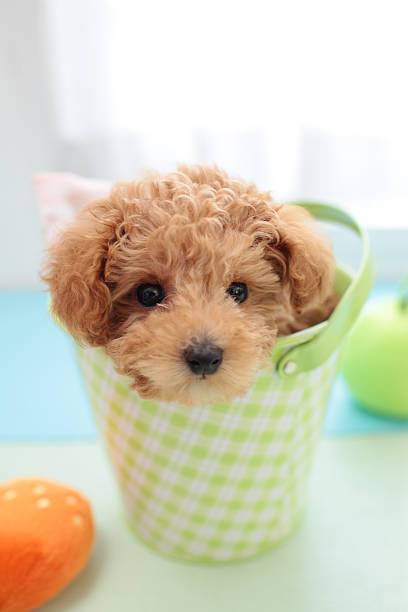

In [90]:
example['image']

# 3. Оформление датасета в виде объекта класса Dataset из PyTorch

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torchvision import transforms
from torch.utils.data import DataLoader

In [92]:
class IsItFoodOrDog(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.length = len(self.dataset)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224), antialias=True),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        train_images = self.transform(self.dataset[index]['image'])
        train_labels = self.dataset[index]['label']
        return train_images, train_labels


In [93]:
train_dataset = IsItFoodOrDog(dataset["train"])
test_dataset = IsItFoodOrDog(dataset["test"])

# 4. Оформим датасет в Dataloader

In [94]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [95]:
class_names = dataset["test"].features["label"].names
dataset_sizes = {
    'train': len(dataset['train']),
    'test': len(dataset['test']),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

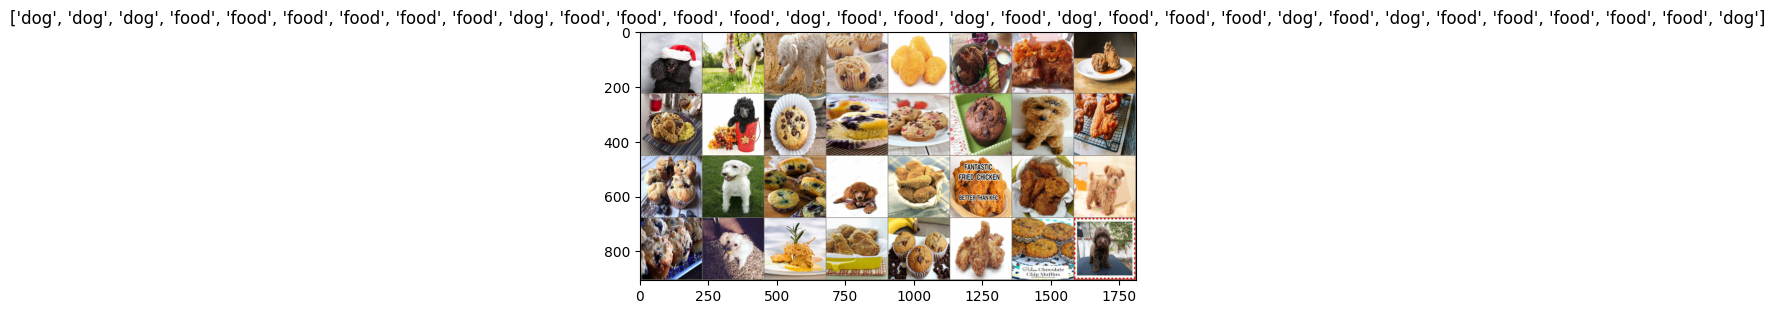

In [96]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(train_dataloader))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 5. Реализуем собственную нейросеть

In [99]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_acc = 0.0
    best_model_wts = model.state_dict()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataset_sizes = {'train': len(train_dataloader.dataset), 'test': len(test_dataloader.dataset)}

    for epoch in range(num_epochs):
        print('Epoch [{}/{}]'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'test']:
            model.train(phase == 'train')
            running_loss = 0.0
            running_corrects = 0

            current_dataloader = train_dataloader if phase == 'train' else test_dataloader

            for inputs, labels in current_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

            print('{} Loss: {:.4f} | Accuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        print()

    print('Training complete')
    print('Best val Accuracy: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

  

In [104]:
model = nn.Sequential(
    nn.Conv2d(3, 32, 3),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, 3, 3),
    nn.ReLU(),
    nn.MaxPool2d(3),

    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, 3, 3),
    nn.ReLU(),
    nn.MaxPool2d(3),

    nn.BatchNorm2d(64),

    nn.Flatten(),

    nn.Linear(576, 32),
    nn.Linear(32, 2),
)


model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)

optimizer_ft = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)
model_fitted = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch [1/10]
----------
train Loss: 0.7700 | Accuracy: 0.7314
test Loss: 0.9180 | Accuracy: 0.7678

Epoch [2/10]
----------
train Loss: 0.5832 | Accuracy: 0.7629
test Loss: 0.3531 | Accuracy: 0.8511

Epoch [3/10]
----------
train Loss: 0.4065 | Accuracy: 0.8267
test Loss: 0.3407 | Accuracy: 0.8522

Epoch [4/10]
----------
train Loss: 0.3298 | Accuracy: 0.8614
test Loss: 0.2811 | Accuracy: 0.8978

Epoch [5/10]
----------
train Loss: 0.3070 | Accuracy: 0.8671
test Loss: 0.2751 | Accuracy: 0.8878

Epoch [6/10]
----------
train Loss: 0.3019 | Accuracy: 0.8686
test Loss: 0.2773 | Accuracy: 0.8889

Epoch [7/10]
----------
train Loss: 0.2952 | Accuracy: 0.8762
test Loss: 0.2684 | Accuracy: 0.8967

Epoch [8/10]
----------
train Loss: 0.2895 | Accuracy: 0.8767
test Loss: 0.2698 | Accuracy: 0.8944

Epoch [9/10]
----------
train Loss: 0.2929 | Accuracy: 0.8767
test Loss: 0.2679 | Accuracy: 0.9000

Epoch [10/10]
----------
train Loss: 0.2902 | Accuracy: 0.8757
test Loss: 0.2694 | Accuracy: 0.8956


# Результаты обучения

In [75]:
def predict(img):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    img = transform(img)
    output = model_fitted(img.unsqueeze(0).to(device))
    prediction = output.argmax(dim=1).item()

    return id2label[prediction]

In [76]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

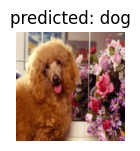

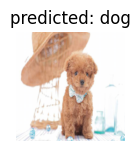

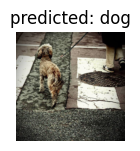

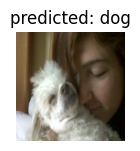

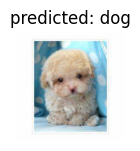

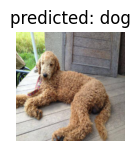

In [77]:
visualize_model(model_fitted, 6)

# 6. Обучение с Transfer Learning ResNet152

In [106]:
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss().to(device)

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=1, gamma=0.1)

In [107]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch [1/10]
----------
train Loss: 0.0558 | Accuracy: 0.9738
test Loss: 0.3862 | Accuracy: 0.8900

Epoch [2/10]
----------
train Loss: 0.0240 | Accuracy: 0.9933
test Loss: 0.0074 | Accuracy: 0.9967

Epoch [3/10]
----------
train Loss: 0.0069 | Accuracy: 0.9986
test Loss: 0.0064 | Accuracy: 0.9967

Epoch [4/10]
----------
train Loss: 0.0063 | Accuracy: 0.9976
test Loss: 0.0069 | Accuracy: 0.9967

Epoch [5/10]
----------
train Loss: 0.0042 | Accuracy: 0.9990
test Loss: 0.0077 | Accuracy: 0.9967

Epoch [6/10]
----------
train Loss: 0.0038 | Accuracy: 0.9990
test Loss: 0.0080 | Accuracy: 0.9967

Epoch [7/10]
----------
train Loss: 0.0069 | Accuracy: 0.9976
test Loss: 0.0089 | Accuracy: 0.9967

Epoch [8/10]
----------
train Loss: 0.0022 | Accuracy: 0.9990
test Loss: 0.0084 | Accuracy: 0.9967

Epoch [9/10]
----------
train Loss: 0.0042 | Accuracy: 0.9986
test Loss: 0.0079 | Accuracy: 0.9967

Epoch [10/10]
----------
train Loss: 0.0044 | Accuracy: 0.9986
test Loss: 0.0080 | Accuracy: 0.9967


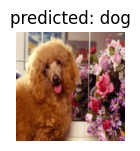

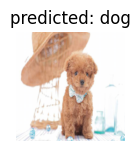

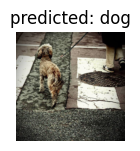

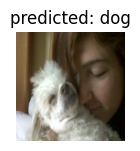

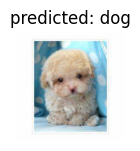

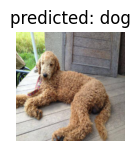

In [108]:
visualize_model(model_ft)

# 7.Выводы

После обучения собственная модель имела:
- train Loss: 0.0044 | Accuracy: 0.9986
- test Loss: 0.0080 | Accuracy: 0.9967
- Best val Accuracy: 0.900000

После Transfer Learning на ResNet152 получили:
- train Loss: 0.0044 | Accuracy: 0.9986
- test Loss: 0.0080 | Accuracy: 0.9967
- Best val Accuracy: 0.999048

По итогам первого обучения нейросеть имела нелохие показатели точности, но всё равно могла совершать ошибки .Однако осле обучеения на Transfer Learning  ResNet152 вероятность ошибки была сведена к минимуму